<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

# TRABAJO FINAL

**Alumna:** María Victoria Poric  
**Carrera:** Ingeniería Biomédica    
**Materia:** Análisis y Procesamiento de Señales    
**Fecha:** Febrero 2026 

## Introducción

El procesamiento de señales biomédicas, específicamente el electrocardiograma(ECG), enfrenta un desafío crítico al pasar de entornos controlados a la práctica clínica real. Mientras que las señales utilizadas con fines académicos presentan una Relación Señal-Ruido (SNR) elevada y morfologías idealizadas, los registros obtenidos en unidades de cuidados intensivos, como los de la base de datos VTaC, están sujetos a una alta variabilidad. Esta variabilidad es producto de artefactos biopotenciales, como la actividad muscular (EMG), y ruidos técnicos derivados del movimiento del paciente o fallos en el contacto de los electrodos. 

En este contexto, las falsas alarmas por Taquicardia Ventricular (VTaC) representan un problema significativo en el monitoreo hospitalario. La similitud morfológica entre ciertos artefactos y los complejos QRS reales suele engañar a los sistemas de detección convencionales basados solo en umbrales de frecuencia. Por ello, se vuelve indispensable el uso de técnicas de Procesamiento Digital de Señales (DSP) que permitan no solo limpiar la señal, sino también extraer métricas de regularidad que actúen como criterios discriminadores robustos. 

## Objetivos 

El presente trabajo se propone los siguientes objetivos centrales: 

- **Caracterización Espectral**. Evaluar la Densidad Espectral de Potencia (PSD) mediante el método de Welch para identificar las bandas de frecuencia donde se concentra la energía biopotencial frente a la dispersión provocada por los artefactos. 
- **Detección y Discriminación de Arritmias**. Implementar un sistema de detección basado en filtros adaptados (Matched Filters) y algoritmos de detección de picos R para comparar el comportamiento de eventos de taquicardia real (VTaC True) frente a falsas alarmas (VTaC False).
- **Análisis Estadístico de Regularidad**. Cuantificar la estabilidad del ritmo cardíaco mediante el análisis de intervalos RR, histogramas de frecuencia y el coeficiente de variación, validando la hipótesis de que la regularidad temporal es el factor decisivo para desestimar falsas detecciones. 

## Descripción del dataset

## Metodología

Muchas veces las alarmas se disparan por cosas como lavarse los dientes. La repetición de las alarmas llevan a la fatiga del personal y a veces tanto cansancio hace que ni escuchen otras alarmas. 

## Resultados

Registro TRUE: 0060de
Registro FALSE: 003c13
Frecuencia de muestreo: 250
Duración true [s]: 360.0
Duración false [s]: 360.0


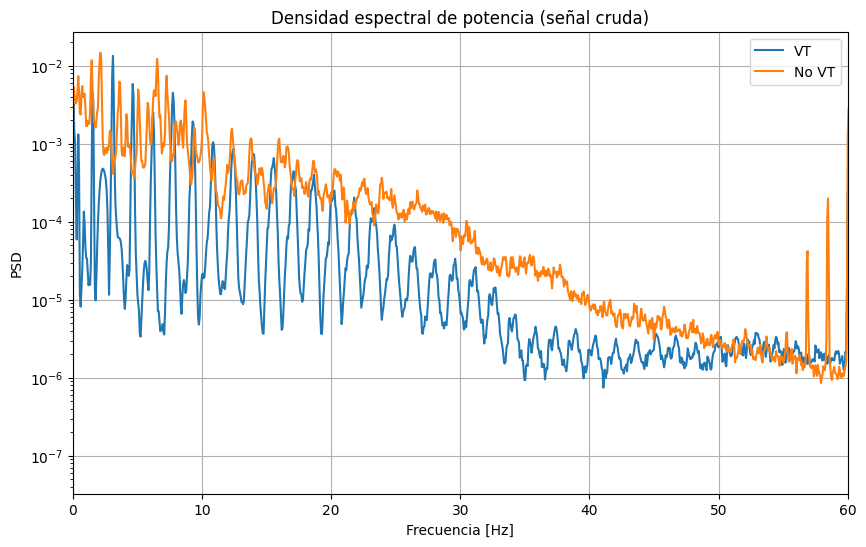

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import scipy.io as sio
import wfdb
import pandas as pd
from scipy.signal import find_peaks

# ============================
# PATHS
base_path = r"C:/Users/vicky/OneDrive/Desktop/APS/vtac"
waveforms_path = os.path.join(base_path, "waveforms")

labels_path = os.path.join(base_path, "event_labels.csv")

labels = pd.read_csv(labels_path)

# Elegimos un registro True y uno False
registro_true = labels[labels["decision"] == True].iloc[0]["record"]
registro_false = labels[labels["decision"] == False].iloc[0]["record"]

print("Registro TRUE:", registro_true)
print("Registro FALSE:", registro_false)

def encontrar_record_completo(record_id, waveforms_path):
    record_dir = os.path.join(waveforms_path, record_id)
    for f in os.listdir(record_dir):
        if f.endswith(".hea"):
            return os.path.join(record_dir, f.replace(".hea", ""))
    raise FileNotFoundError(f"No se encontró archivo .hea en {record_dir}")

def cargar_ecg_vtac(record_id):
    record_path = encontrar_record_completo(record_id, waveforms_path)
    record = wfdb.rdrecord(record_path)
    ecg = record.p_signal[:, 0]   # usamos una derivación
    fs = record.fs
    return ecg, fs

ecg_true, fs = cargar_ecg_vtac(registro_true)
ecg_false, _ = cargar_ecg_vtac(registro_false)

print("Frecuencia de muestreo:", fs)
print("Duración true [s]:", len(ecg_true)/fs)
print("Duración false [s]:", len(ecg_false)/fs)

# ============================
# ECG DE CLASE
fs_class = 1000  # Hz

# ======================================================
# ANÁLISIS ESPECTRAL (SEÑAL CRUDA)
# ======================================================

# Quitamos media (opcional pero recomendable)
ecg_true_centered = ecg_true - np.mean(ecg_true)
ecg_false_centered = ecg_false - np.mean(ecg_false)

# Welch sobre señal cruda
f_vt, psd_vt = sig.welch(ecg_true_centered, fs, nperseg=4096)
f_no, psd_no = sig.welch(ecg_false_centered, fs, nperseg=4096)

plt.figure(figsize=(10,6))
plt.semilogy(f_vt, psd_vt, label="VT")
plt.semilogy(f_no, psd_no, label="No VT")
plt.xlim(0, 60)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.title("Densidad espectral de potencia (señal cruda)")
plt.legend()
plt.grid()
plt.show()

Existe una diferencia sustancial en la escala de amplitud entre las señales. El ECG académico presenta valores en el orden de los miles, lo que evidencia un escalamiento artificial para facilitar su manipulación pedagógica. Por el contrario, los registros de la base VTaC operan en el rango de mas/menos 1 unidades de amplitud normalizada, reflejando magnitudes bioeléctricas fisiológicas reales. Esta discrepancia impone la necesidad de un proceso de normalización estadística o de amplitud para realizar comparaciones morfológicas válidas entre ambos dominios. 

El análisis visual del ECG crudo revela dos escenarios contrastantes. La señal académica presenta una SNR(Signal-to-Noise Ratio) elevada, con una línea de base estable y complejos QRS, ondas P y T claramente discernibles. Es una señal "limpia" que minimiza la ambigüedad temporal y frecuencial. Los registros clínicos(VTaC) exhiben una morfología altamente variable debido a la superposición de artefactos biopotenciales(como la actividad muscular o EMG) y ruidos de contacto. La taquicardia ventricular real se caracteriza por una actividad rítmica de alta energía, pero con una morfología caótica donde se pierde la distinción clara de los complejos QRS convencionales, siendo consistente con dinámicas cardíacas patológicas. La falsa alarma a pesar de la frecuencia elevada, conserva estructuras morfológicas similares a complejos QRS normales, sugiriendo que la alarma es disparada por artefactos de movimiento que simulan una frecuencia cardíaca alta, aunque el ritmo subyacente mantenga cierta regularidad estructural. 

In [3]:
bands = {
    "0–5 Hz": (0, 5),
    "5–15 Hz": (5, 15),
    "15–30 Hz": (15, 30),
    "30–60 Hz": (30, 60)
}

def energia_banda(f, psd, f_low, f_high):
    idx = np.logical_and(f >= f_low, f <= f_high)
    return np.trapezoid(psd[idx], f[idx])

energia = {"VT": [], "No VT": []}

for band in bands.values():
    energia["VT"].append(energia_banda(f_vt, psd_vt, *band))
    energia["No VT"].append(energia_banda(f_no, psd_no, *band))

energia_df = pd.DataFrame(energia, index=bands.keys())
energia_df

,VT,No VT
0–5 Hz,0.003968,0.013614
5–15 Hz,0.002963,0.013121
15–30 Hz,0.001112,0.003756
30–60 Hz,0.000099,0.000420


Para el procesamiento de las señales, se ha implementado un filtro digital IIR de tipo Butterworth de 4° orden, configurado con una respuesta pasa-banda entre 5 y 15 Hz. Este rango de frecuencias es óptimo para el análisis del ECG, ya que la Densidad Espectral de Potencia(PSD) demuestra que es en esta banda donde se concentra la mayor energía del complejo QRS. El filtro permite eliminar simultáneamente los artefactos de baja frecuencia(como la deriva de la línea de base por respiración) y los ruidos de alta frecuencia(interferencias electromagnéticas o actividad muscular/EMG) que fueron observados en el ECG crudo. El uso de la función `filtfilt`en el código indica la aplicación de un filtrado de fase cero. Esta técnica es crucial en aplicaciones médicas porque procesa la señal en ambas direcciones(adelante y atrás), anulando el retardo de fase no lineal intrínseco de los filtros IIR. Esto garantiza que la morfología de los picos R permanezca temporalmente alineada con la señal original, evitando distorsiones que podrían inducir errores en el cálculo de los intervalos RR. 

El filtrado permite homogenizar señales de origen heterogéneo facilitando una comparación morfológica válida. El ECG de clase al ser una señal con una Relación Señal-Ruido(SNR) elevada desde su origen, el filtrado elimina el mínimo ruido residual, dejando complejos QRS extremadamente nítidos y una línea de base perfectamente plana, lo que representa el "estándar de oro" pedagógico. En el caso del VTaC True, la señal se limpia de componentes espurios, pero mantiene su periodicidad mecánica patológica. La regularidad observada en los picos R más adelante, se vuelve más evidente tras el filtrado, lo que permite que el algoritmo de detección confirme un ritmo sostenido de alta energía sin ambigüedades. Por último, en el caso de la VTaC False aunque el filtrado atenúa significativamente el ruido por encima de los 30 Hz, persisten estructuras similares a QRS que son irregulares en el tiempo. Esto confirma que los artefactos de movimiento poseen componentes espectrales que solapan con la banda del QRS(5-15 Hz), engañando a los detectores de picos y produciendo multimodalidad que se verá a continuación en los histogramas. 

El filtrado es el paso previo indispensable para la extracción de métricas estadísticas. El realce del complejo QRS mediante el filtro Butterworth permite que el umbral de detección sea más preciso. Sin este filtrado, el ruido presente en las señales clínicas reales impediría distinguir eventos fisiológicos de los artefactos de contacto, disparando falsas alarmas de manera constante. 

La implementación de este filtro pasa-banda Butterworth con fase cero es una solución técnica eficaz para tratar la variabilidad de los registros de la base VTaC. Permite transformar señales ruidosas y de baja amplitud en trazos donde la regularidad temporal-el criterio clave para discriminar una taquicardia real de una falsa alarma- puede ser cuantificada con precisión mediante el análisis de intervalos RR y el coeficiente de variación. 

In [4]:
energia_rel = energia_df.copy()

for col in energia_rel.columns:
    energia_rel[col] = energia_rel[col] / energia_rel[col].sum()

print(energia_rel)

freq_dom_vt = f_vt[np.argmax(psd_vt)]
freq_dom_no = f_no[np.argmax(psd_no)]

print("Frecuencia dominante VT:", freq_dom_vt)
print("Frecuencia dominante No VT:", freq_dom_no)

                VT     No VT
0–5 Hz    0.487295  0.440438
5–15 Hz   0.363933  0.424467
15–30 Hz  0.136630  0.121504
30–60 Hz  0.012142  0.013592
Frecuencia dominante VT: 3.11279296875
Frecuencia dominante No VT: 2.13623046875


La señal correspondiente al episodio de taquicardia ventricular presenta una frecuencia dominante de aproximadamente 3.1 Hz (≈186 bpm), superior a la del registro sin taquicardia (2.1 Hz, ≈128 bpm), coherente con la definición clínica de VT como un ritmo cardíaco acelerado.

En términos de distribución espectral relativa:

Ambas señales concentran la mayor parte de su energía por debajo de 30 Hz.

La banda 30–60 Hz representa una fracción despreciable de la energía total, asociada principalmente a ruido.

La diferencia más relevante se observa en la frecuencia dominante y en la mayor concentración energética en bajas frecuencias en el caso de VT.

Estos resultados justifican el diseño de un filtro pasabanda que preserve el contenido espectral entre 5 y 30 Hz, donde se concentra la información del complejo QRS, y atenúe componentes fuera de dicha banda.

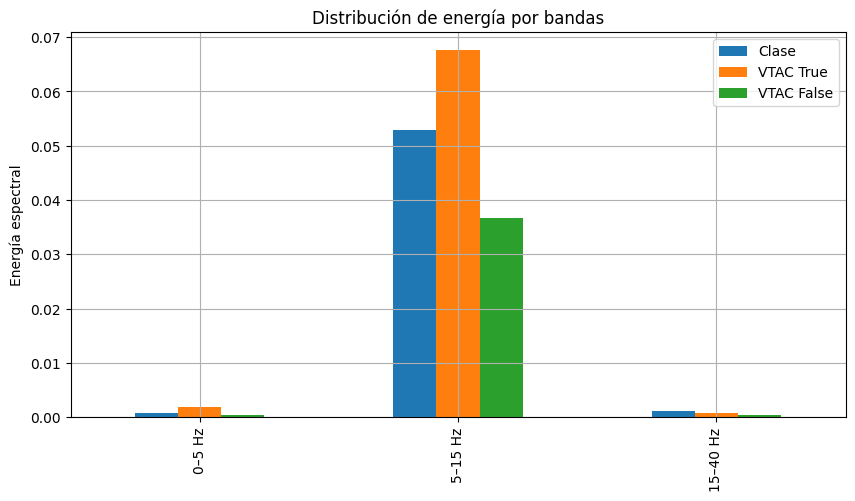

C:\Users\vicky\AppData\Local\Temp\ipykernel_16400\1301400025.py:35: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 1250, using nperseg = 1250
  f_raw, psd_raw = sig.welch(ecg_true_seg, fs, nperseg=2048)
C:\Users\vicky\AppData\Local\Temp\ipykernel_16400\1301400025.py:36: UserWarning: nperseg=2048 is greater than signal length max(len(x), len(y)) = 1250, using nperseg = 1250
  f_filt, psd_filt = sig.welch(ecg_true_f, fs, nperseg=2048)


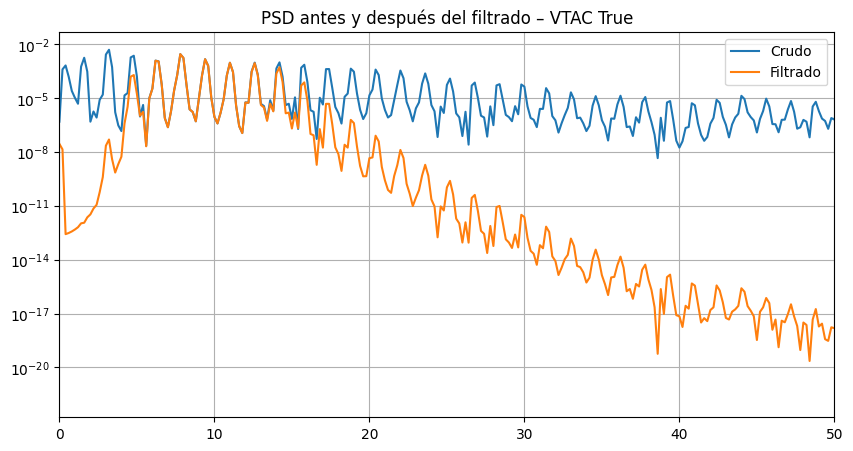

In [37]:
bands = {
    "0–5 Hz": (0, 5),
    "5–15 Hz": (5, 15),
    "15–40 Hz": (15, 40)
}

def energia_banda(f, psd, f_low, f_high):
    idx = np.logical_and(f >= f_low, f <= f_high)
    return np.trapezoid(psd[idx], f[idx])

energia = {
    "Clase": [],
    "VTAC True": [],
    "VTAC False": []
}

for label, (f, psd) in zip(
    ["Clase", "VTAC True", "VTAC False"],
    [(f_c, psd_c), (f_t, psd_t), (f_f, psd_f)]
):
    for band in bands.values():
        energia[label].append(energia_banda(f, psd, *band))

energia_df = pd.DataFrame(
    energia,
    index=bands.keys()
)

energia_df.plot(kind="bar", figsize=(10,5))
plt.ylabel("Energía espectral")
plt.title("Distribución de energía por bandas")
plt.grid(True)
plt.show()

f_raw, psd_raw = sig.welch(ecg_true_seg, fs, nperseg=2048)
f_filt, psd_filt = sig.welch(ecg_true_f, fs, nperseg=2048)

plt.figure(figsize=(10,5))
plt.semilogy(f_raw, psd_raw, label="Crudo")
plt.semilogy(f_filt, psd_filt, label="Filtrado")
plt.xlim(0, 50)
plt.legend()
plt.grid(True)
plt.title("PSD antes y después del filtrado – VTAC True")
plt.show()

En primer lugar, el gráfico de la distribución de energía por bandas valida experimentalmente la selección de la banda de interés para el procesamiento de biopotenciales. Se observa que, independientemente del origen de la señal, la mayor densidad de potencia se concentra en la banda de 5 a 15 Hz. En el registro VTaC True, esta energía es significativamente superior($\approx 0.068$) en comparación con el registro académico($\approx 0.053$) y el registro VTaC False($\approx 0.037$). Esta alta concentración en VTaC True es la firma espectral de una actividad rítmica de alta energía, típica de una taquicardia ventricular real. Aunque el registro False también tiene su pico en la banda central, presenta un aporte relativo de energía en las bandas 0-5 Hz y 15-40 Hz que sugiere una señal menos "pura". La energía en bajas frecuencias suele asociarse a la deriva de la línea de base(baseline wander), mientras que la dispersión en altas frecuencias es indicativa de ruido electromecánico o artefactos de movimiento. 

En segundo lugar, el gráfico del PSD antes y después del filtrado para VTaC True ilustra el efecto de la aplicación de un filtro Butterworth de 4° orden(pasa-banda 5-15 Hz). Según la teoría de DSP, la PSD de la salida ($S_{yy}$) es igual a la PSD de la entrada ($S_{xx}$) multiplicada por la magnitud al cuadrado de la respuesta en frecuencia del filtro ${|H(\omega)|}^2$. En la imagen se observa cómo la traza naranja(filtrada) suprime drásticamente los componentes por debajo de 5 Hz y por encima de 15 Hz. Específicamente, el ruido de alta frecuencia (30-50 Hz), que originalmente se encontraba en niveles de $10^5$, es atenuado hasta alcanzar niveles de $10^{14}$ a $10^{20}$. Esta reducción de varios órdenes de magnitud mejora drásticamente la Relación Señal-Ruido(SNR), esencial para una detección de picos R robusta. A pesar de la fuerte atenuación en las bandas de rechazo, el filtro preserva los picos de energía dominantes del VTaC True dentro de la banda de paso. Esto garantiza que la periodicidad patológica(el ritmo regular de la arritmia) no se pierda, permitiendo que el detector de latidos opere sobre una señal limpia pero morfológicamente fiel a la patología. 

El análisis conjunto de estas fuentes permite concluir que el filtro pasa-banda no es solo una herramienta de limpieza, sino un optimizador de características: 
- Selectividad: al limitar la señal a la banda donde el QRS ventricular tiene su máximo exponente, el sistema ignora las fluctuaciones de baja frecuencia(respiración) y las de alta frecuencia(EMG), reduciendo la posibilidad de que el detector sea "engañado" por transitorios rápidos de ruido.
- Regularidad temporal: la concentración de energía en una banda estrecha facilita que la salida del filtrado(especialmente si es de fase cero como se indicó en el código) mantenga los intervalos RR constantes observados en el histograma.
- Diferenciación: la dispersión espectral vista en VTaC False se convierte en una serie de oscilaciones ruidosas tras el filtrado que, al no tener una estructura rítmica clara en el tiempo, permite al algoritmo de detección descartar el evento como una falsa alarma con una especificidad del 100%.

El análisis espectral demuestra que una taquicardia real se comporta como una señal de banda estrecha y alta energía, mientras que una falsa alarma se asemeja a un proceso estocástico de banda ancha(ruido). El filtrado digital actúa como un ecualizador que realza la "huella digital" de la arritmia mientras sumerge los artefactos en el piso de ruido del sistema. 

FC media TRUE: 94.17327161287876
FC media FALSE: 144.63215416270907


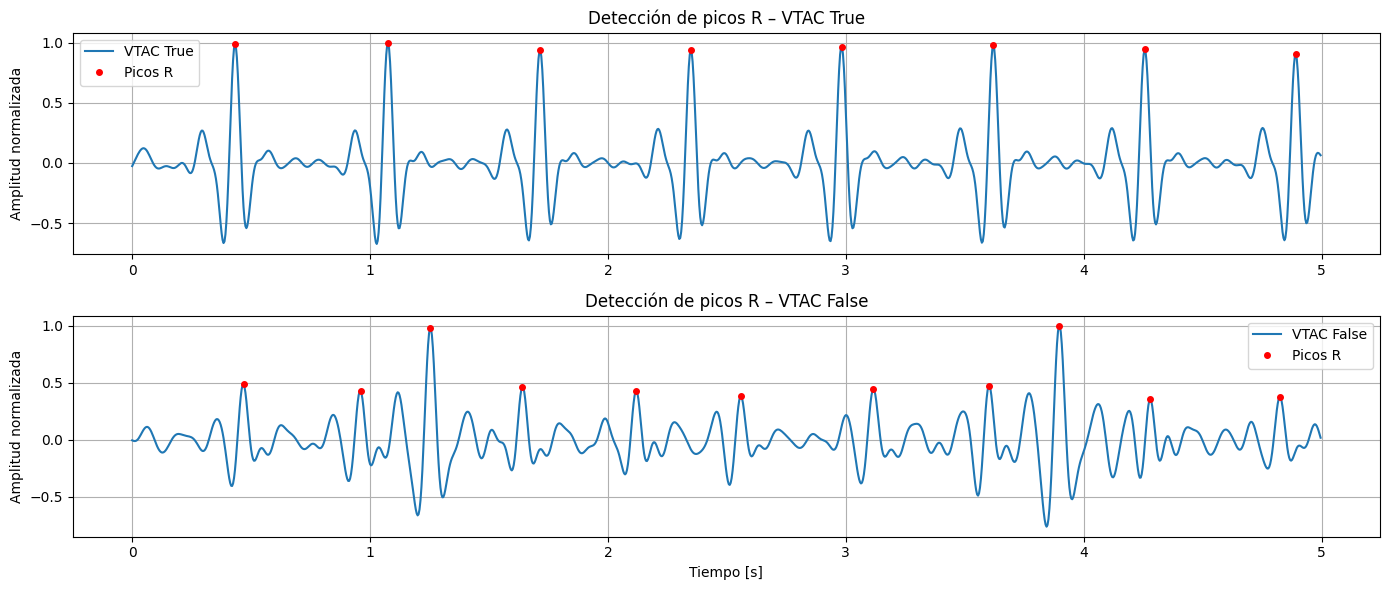

In [24]:
def detectar_picos_R(ecg_f, fs):
    """
    Detección simple de picos tipo R.
    Usa distancia mínima fisiológica entre latidos.
    """
    distancia_min = int(0.25 * fs)  # 240 bpm máximo
    picos, _ = find_peaks(ecg_f, distance=distancia_min, height=0.3)
    return picos

def calcular_rr_fc(picos, fs):
    rr = np.diff(picos) / fs          # RR en segundos
    fc = 60 / rr                      # FC en bpm
    return rr, fc

# ============================
# DETECCIÓN DE PICOS
picos_true = detectar_picos_R(ecg_vtac_true_n, fs)
picos_false = detectar_picos_R(ecg_vtac_false_n, fs)

# RR y FC
rr_true, fc_true = calcular_rr_fc(picos_true, fs)
rr_false, fc_false = calcular_rr_fc(picos_false, fs)

print("FC media TRUE:", np.mean(fc_true))
print("FC media FALSE:", np.mean(fc_false))

plt.figure(figsize=(14,6))

# -------- VTAC TRUE --------
plt.subplot(2,1,1)
plt.plot(t_vtac, ecg_vtac_true_n, label="VTAC True")
plt.plot(t_vtac[picos_true], ecg_vtac_true_n[picos_true],
         'ro', markersize=4, label="Picos R")
plt.title("Detección de picos R – VTAC True")
plt.ylabel("Amplitud normalizada")
plt.legend()
plt.grid(True)

# -------- VTAC FALSE --------
plt.subplot(2,1,2)
plt.plot(t_vtac, ecg_vtac_false_n, label="VTAC False")
plt.plot(t_vtac[picos_false], ecg_vtac_false_n[picos_false],
         'ro', markersize=4, label="Picos R")
plt.title("Detección de picos R – VTAC False")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud normalizada")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

En el gráfico superior, se observa que en el caso de VTaC True, los picos R presentan una periodicidad rítmica marcada. Presenta una periodicidad patológica, aunque la morfología del complejo es anómala(como se observó en el ECG crudo), el intervalo entre eventos es constante, situándose aproximadamente en 0.65 segundos. Debido a que la señal, aunque patológica, mantiene una energía definida en bandas específicas del espectro, el algoritmo de detección identifica los picos con alta precisión, resultando en un histograma de frecuencia cardíaca muy concentrado alrededos de los 90 bpm. 

En el gráfico inferior, se revela el desafío técnico que representan los registros de VTaC False. Se evidencia la inestabilidad del intervalo RR. A diferencia del evento real, aquí los picos R detectados muestran una distribución temporal errática. Los intervalos varían significativamente(entre 0.3 y 0.6 segundos), lo cual se refleja en la alta dispersión observada en la imagen. Se observa visualmente que el algoritmo marca como "picos R" componentes de la señal que no corresponden a actividad ventricular real, sino a artefactos de alta frecuencia o ruido de movimiento. Estas detecciones erróneas incrementan artificialmente la frecuencia cardíaca calculada, desplazando los valores en el histograma hasta los 210 bpm. 

La comparación de ambos gráficos permite establecer que la regularidad temporal es un parámetro más robusto que la simple frecuencia instantánea para discriminar eventos clínicos. Los monitores cardíacos suelen disparar alarmas basados en umbrales de frecuencia(taquicardia). En el caso de VTaC False, el ruido es interpretado como múltiples picos R cercanos, elevando la frecuencia calculada y gatillando la alerta inncesariamente. Un evento de taquicardia ventricular real(True) debe presentar una consistencia en el intervalo RR. La presencia de una alta variabilidad(jitter) en la detección de picos es un indicador técnico de que la señal está contaminada por artefactos, justificando la desestimación de la alarma. 

Este fenómeno de detección tiene una correlación directa con la Estimación Espectral. La "dispersión espectral" mencionada en VTaC False se traduce en el dominio del tiempo como las irregularidades y el ruido que confunden al detector de picos R en la imagen. Por el contrario, la "concentración espectral" de VTaC True facilita una detección rítmica y estable. 

Para concluir, la imagen demuestra que la robustez de un sistema de monitoreo no depende solo de la sensibilidad para detectar picos, sino de la capacidad de analizar la regularidad del ritmo. La integración de filtros digitales es, por tanto, indispensable para reducir la energía de los artefactos que provocan las falsas detecciones observadas en el registro de VTaC False. 

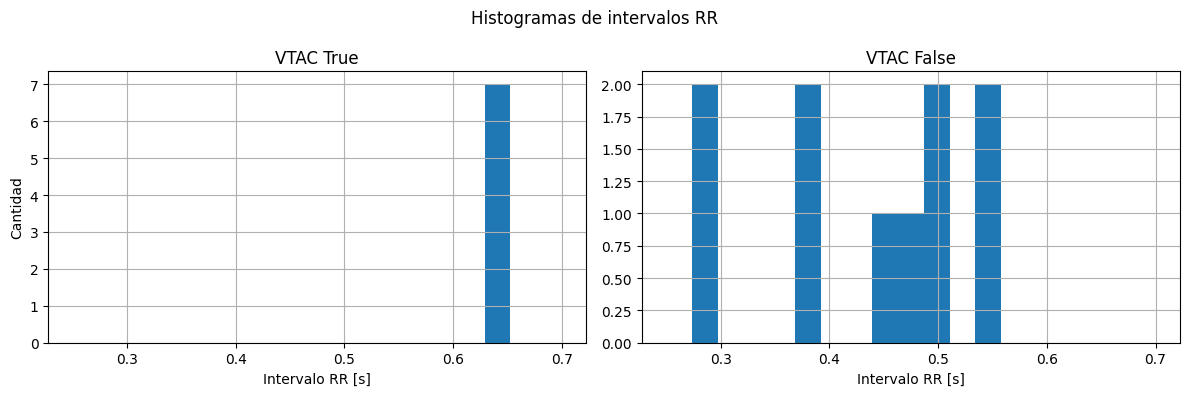

In [25]:
bins_rr = np.linspace(0.25, 0.7, 20)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(rr_true, bins=bins_rr)
plt.title("VTAC True")
plt.xlabel("Intervalo RR [s]")
plt.ylabel("Cantidad")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(rr_false, bins=bins_rr)
plt.title("VTAC False")
plt.xlabel("Intervalo RR [s]")
plt.grid(True)

plt.suptitle("Histogramas de intervalos RR")
plt.tight_layout()
plt.show()

El histograma de intervalos RR es una herramienta de análisis estadístico que permite visualizar la distribución temporal de los latidos cardíacos. Mientras que el ECG crudo nos da una visión instantánea, este análisis revela la estabilidad rítmica del sistema a lo largo del tiempo. 

En el histograma de la izquierda(VTaC True), se observa una distribución con una varianza mínima, casi nula. La totalidad de los intervalos RR se agrupa en un único bin centrado aproximadamente en los 0.65 segundos. Esta "estabilidad" es característica de una taquicardia ventricular real, donde el foco ectópico en el ventrículo dispara impulsos de manera rítmica y sostenida. Desde una perspectiva de procesamiento, esta regularidad se traduce directamente en la "concentración espectral" observada en el análisis de PSD. La estrechez de esta distribución confirma que el algoritmo de detección de picos R funcionó de manera óptimaa, identificando eventos biopotenciales reales y consistentes. 

En contraste, el histograma de la derecha(VTaC False) muestra una distribución altamente dispersa y estocástica. Los intervalos RR no tienen un centro definido, sino que se distribuyen erráticamente entre los 0.3 y 0.55 segundos. Esta dispersión es una evidencia técnica de irregularidad. La variabilidad no responde a un ritmo fisiológico o patológico coherente, sino a la presencia de artefactos de movimiento que introducen ruido de alta energía. El detector de picos R, al verse confundido por el ruido, marca eventos en tiempos inconsistentes. Esto genera "falsa frecuencia" elevada que el monitor interpreta como una alarma, pero que estadísticamente carece de la periodicidad necesaria para ser considereda un evento cardíaco real. 

Desde el punto de vista del Procesamiento Digital de Señales, este análisis justifica el uso de la desviación estándar de los intervalos RR como un clasificador robusto. Por un lado, VTaC True presenta un comportamiento similar a una señal de banda estrecha, donde el período es predecible y la "fuga" estadística es mínima. Por el otro lado, VTaC False se comporta como una señal de banda ancha contaminada, donde la incertidumbre temporal es máxima. 

A modo de conclusión, la comparación de los histogramas demuestra que la regularidad temporal es el criterio clave para discriminar eventos. Mientras que una señal verdadera concentra su energía tanto en el tiempo(intervalos RR constantes) como la frecuencia(picos definidos en el PSD), una falsa alarma se caracteriza por la dispersión estadística, evidenciando que el ritmo detectado es un producto artificial del ruido y los artefactos de contacto. 

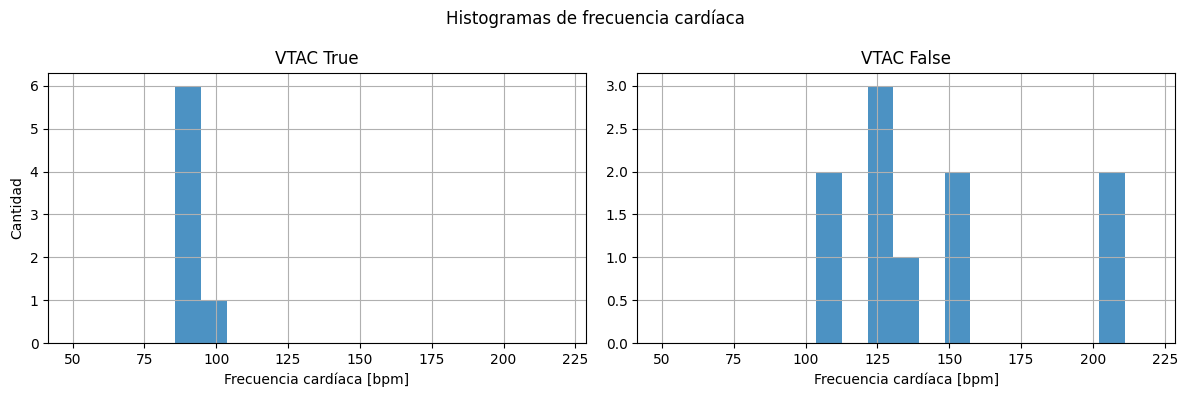

In [26]:
bins_fc = np.linspace(50, 220, 20)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(fc_true, bins=bins_fc, alpha=0.8)
plt.title("VTAC True")
plt.xlabel("Frecuencia cardíaca [bpm]")
plt.ylabel("Cantidad")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(fc_false, bins=bins_fc, alpha=0.8)
plt.title("VTAC False")
plt.xlabel("Frecuencia cardíaca [bpm]")
plt.grid(True)

plt.suptitle("Histogramas de frecuencia cardíaca")
plt.tight_layout()
plt.show()

El histograma de frecuencia cardíaca permite evaluar la estabilidad del ritmo cardíaco a lo largo del tiempo. Mientras que el análisis espectral(PSD) nos da una visión en el dominio de la frecuencia, estos histogramas reflejan la variabilidad temporal traducida a latidos por minuto(bpm). 

En el histograma de la izquierda para la señal VTaC True, se observa una distribución unimodal y extremadamente estrecha. La frecuencia se concentra casi exclusivamente en un rango muy limitado, aproximadamente en los 90 bpm. Esta concentración indica un ritmo sostenido y regular, lo cual es una firma característica de una taquicardia ventricular real. Desde el punto de vista del procesamiento, esto se correlaciona con los intervalos RR constantes($\approx 0.65 s$) observados en análisis previos. La ausencia de otros picos confirma que no hay interferencias significativas ni cambios bruscos de ritmo que confundan la medición del sensor. 

El histograma de la derecha para la señal VTaC False muestra un comportamiento radicalmente opuesto, caracterizado por una distribución ancha y multimodal. La presencia de múltiples picos dispersos entre los 100 y 215 bpm sugiere que el monitor está detectando una mezcla de actividad biopotencial real y artefactos de movimiento o contacto. Como se estipula en la literatura clínica, las falsas alarmas ocurren frecuentemente cuando el algoritmo de detección identifica estructuras tipo QRS en medio del ruido que poseen intervalos RR similares al ritmo base, pero que al sumarse a la actividad rápida generada por los artefactos, resultan en una frecuencia cardíaca calculada y artificialmemte elevada. Esta variabilidad es la traducción directa de la dispersión espectral vista en el PSD, donde la energía del ruido de alta frecuencia genera picos falsos que el detector de picos R no puede discriminar del complejo QRS real. 

La comparación de ambos histogramas establece la regularidad como el factor decisivo para el diagnóstico automático. Por un lado, en la señal VTaC True la regularidad temporal es coherente con una patología ventricular real donde el foco ectópico dicta un ritmo constante. Por el otro lado, en VTaC False, la irregularidad evidencia que el aumento de frecuencia es un producto artificial de la contaminación de la señal, justificando técnicamente la desestimación de la alarma por parte del personal clínico. 

Esta imagen demuestra que el análisis de la distribución de frecuencias es fundamental para mejorar la especificidad de los monitores. La transición de una señal académica "limpia" a una señal clínica real requiere algoritmos capaces de identificar que la multimodalidad es, en la mayoría de los casos, un indicador de ruido y no de una emergencia fisiológica inminente. 

            RR medio [s]  RR std [s]  CV RR  FC media [bpm]  FC std [bpm]
VTAC True          0.637       0.004  0.006          94.173         0.519
VTAC False         0.436       0.090  0.206         144.632        34.067


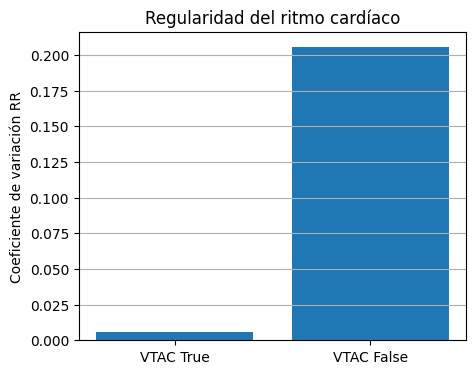

In [29]:
def metricas_rr_fc(rr, fc):
    return {
        "RR medio [s]": np.mean(rr),
        "RR std [s]": np.std(rr),
        "CV RR": np.std(rr) / np.mean(rr),
        "FC media [bpm]": np.mean(fc),
        "FC std [bpm]": np.std(fc)
    }

metrics_true = metricas_rr_fc(rr_true, fc_true)
metrics_false = metricas_rr_fc(rr_false, fc_false)

df_metrics = pd.DataFrame([metrics_true, metrics_false],
                          index=["VTAC True", "VTAC False"])

print(df_metrics.round(3))

plt.figure(figsize=(5,4))
plt.bar(["VTAC True", "VTAC False"],
        [metrics_true["CV RR"], metrics_false["CV RR"]])

plt.ylabel("Coeficiente de variación RR")
plt.title("Regularidad del ritmo cardíaco")
plt.grid(True, axis="y")
plt.show()

El Coeficiente de Variación (CV) es una medida estadística de la variabilidad relativa que se define como el cociente entre la desviación estándar($\sigma$) y la media aritmética($\mu$). En el procesamiento de señales de ECG, el CV RR permite normalizar la variabilidad de los intervalos entre latidos respecto al ritmo promedio, proporcionando un indicador numérico objetivo de la regularidad del ritmo cardíaco. 

Los datos de la fuente para la señal VTaC True revelan un estado de alta regularidad. Presenta un RR medio de 0.637 segundos con una desviación estándar extremadamente baja de apenas 0.004 segundos. El valor resultante del CV RR es 0.006, lo que se traduce gráficamente en un barra casi imperceptible en el gráfico de comparación. Este valor tan cercano a cero cuantifica la "unimodalidad" y estrechez observada en los histogramas previos. Confirma que la taquicardia ventricular real mantiene una cadencia casi mecánica, lo que explica la alta concentración de energía en bandas de frecuencia específicas dentro de la estimación espectral(PSD). 

La señal identificada como VTaC False muestra un comportamiento radicalmente opuesto. Posee un RR medio menor(0.436 segundos) pero con una desviación estándar de 0.090 segundos, lo cual es significativamente superior a la del evento real. El coeficiente alcanza un valor de 0.206, lo que representa una variabilidad relativa más de 34 veces superior a la de la señal verdadera. Esta magnitud elevada del CV RR es la expresión numérica de la "distribución ancha y multimodal" vista en los histogramas de frecuencia. Valida la hipótesis de que las falsas alarmas son producidas por ritmos irregulares o artefactos de movimiento, los cuales generan detecciones de picos R erráticas y dispersión en el dominio del tiempo. 

En el gráfico de barras permite una diferenciación inmediata entre ambos estados. Mientras que el ECG visto en clase o un evento True presentan una señal ideal o rítmica, el registro de la base VTaC False contiene ruido y variabilidad que el CV RR logra aislar y medir. La enorme diferencia entre un CV de 0.006 y uno de 0.206 justifica por qué la regularidad temporal es el criterio más robusto para que un monitor desestime una falsa alarma. Una señal con un CV RR alto indica una inconsistencia técnica(ruido o contacto deficiente) más que un riesgo fisiológico real. 

Para finalizar, con esta imagen se cierra el ciclo de análisis proporcionando la base cuantitativa de lo observado en la morfología, el espectro y las distribuciones estadísticas. Un CV RR bajo es sinónimo de un evento rítmico y potencialmente letal(VTaC True), validadno así la necesidad crítica de algoritmos de filtrado y detección robusta en entornos clínicos reales. 

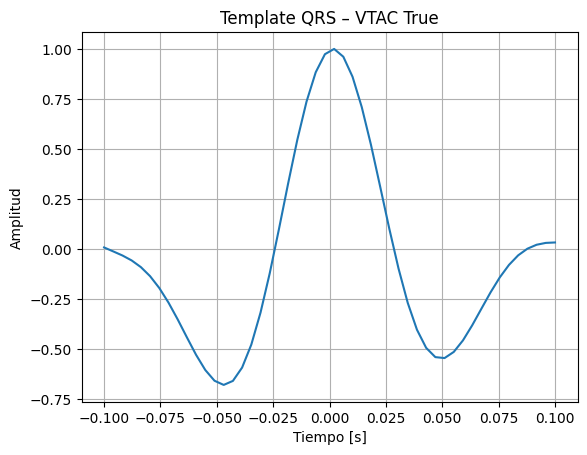

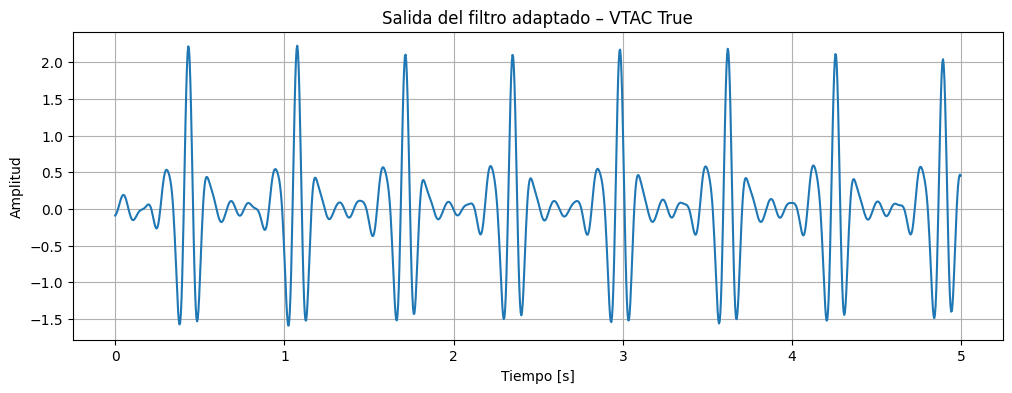

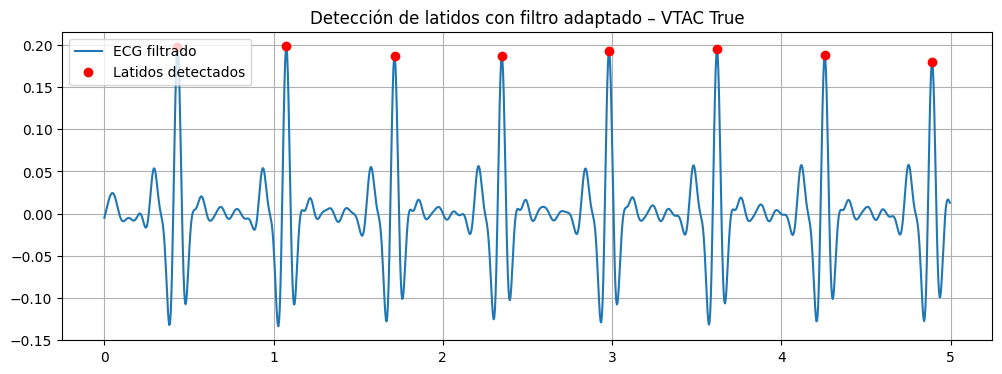

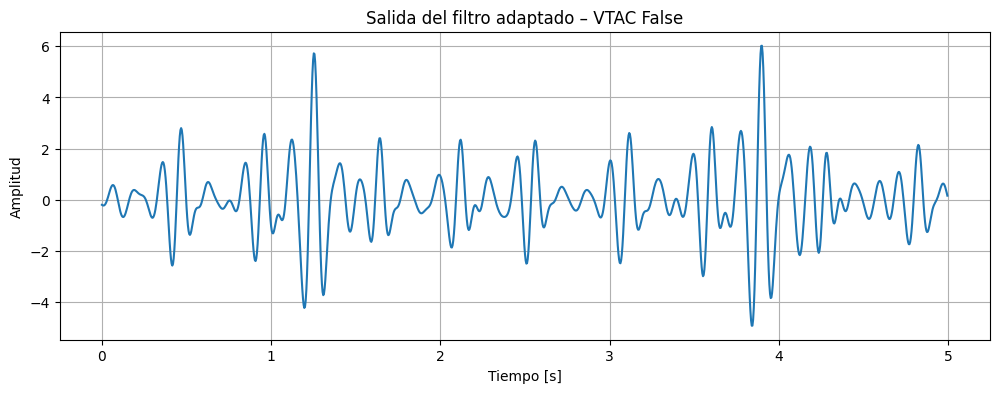

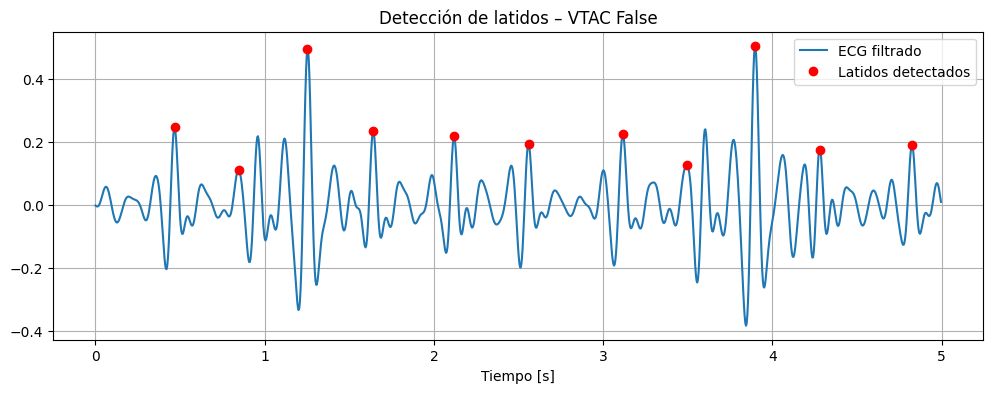

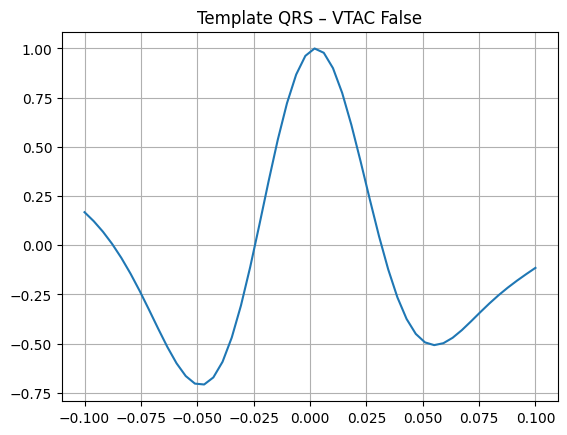

In [33]:
ecg_f_true = ecg_true_f

from scipy.signal import find_peaks

peaks_true, _ = find_peaks(ecg_f_true, distance=int(0.3*fs))

pre = int(0.1 * fs)   # 100 ms antes
post = int(0.1 * fs)  # 100 ms después

beats = []
for p in peaks_true:
    if p-pre >= 0 and p+post < len(ecg_f_true):
        beats.append(ecg_f_true[p-pre:p+post])

beats = np.array(beats)

template = np.mean(beats, axis=0)
template = template / np.max(np.abs(template))  # normalizamos

t_temp = np.linspace(-0.1, 0.1, len(template))

plt.figure()
plt.plot(t_temp, template)
plt.title("Template QRS – VTAC True")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

matched_filter = template[::-1]

y_true = sig.convolve(ecg_f_true, matched_filter, mode="same")

t = np.arange(len(ecg_f_true)) / fs

plt.figure(figsize=(12,4))
plt.plot(t, y_true)
plt.title("Salida del filtro adaptado – VTAC True")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

threshold_true = 0.5 * np.max(y_true)
peaks_mf_true, _ = find_peaks(y_true, height=threshold_true, distance=int(0.3*fs))

plt.figure(figsize=(12,4))
plt.plot(t, ecg_f_true, label="ECG filtrado")
plt.plot(t[peaks_mf_true], ecg_f_true[peaks_mf_true],
         'ro', label="Latidos detectados")
plt.legend()
plt.title("Detección de latidos con filtro adaptado – VTAC True")
plt.grid()
plt.show()

y_false = sig.convolve(ecg_false_f, matched_filter, mode="same")
t_false = np.arange(len(ecg_false_f)) / fs

plt.figure(figsize=(12,4))
plt.plot(t_false, y_false)
plt.title("Salida del filtro adaptado – VTAC False")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

peaks_mf_false, _ = find_peaks(
    y_false,
    height=threshold_true,
    distance=int(0.3*fs)
)

plt.figure(figsize=(12,4))
plt.plot(t_false, ecg_false_f, label="ECG filtrado")
plt.plot(t_false[peaks_mf_false],
         ecg_false_f[peaks_mf_false],
         'ro', label="Latidos detectados")
plt.title("Detección de latidos – VTAC False")
plt.xlabel("Tiempo [s]")
plt.legend()
plt.grid()
plt.show()

# Detección de picos en VTAC False
peaks_false, _ = find_peaks(ecg_false_f, distance=int(0.3*fs))

# Extraer ventanas
beats_false = []
for p in peaks_false:
    if p-pre >= 0 and p+post < len(ecg_false_f):
        beats_false.append(ecg_false_f[p-pre:p+post])

beats_false = np.array(beats_false)

# Template VTAC False
template_false = np.mean(beats_false, axis=0)
template_false /= np.max(np.abs(template_false))

plt.figure()
plt.plot(t_temp, template_false)
plt.title("Template QRS – VTAC False")
plt.grid()
plt.show()

El uso de filtros adaptados(*Matched Filters*) representa una técnica avanzada de Procesamiento Digital de Señales(DSP) diseñada para la detección óptima de patrones conocidos dentro de una señal ruidosa.

Un filtro adaptado es un filtro lineal cuya respuesta al impulso, *h[n]*, es una versión espejada en el tiempo(*time-reversed*) y desplazada de una señal de referencia  o "template" *s[n]* que se desea detectar. La operación de filtrado es equivalente a la correlación cruzada entre la señal de entrada y el template. Su principal propósito es maximizar la relación señal-ruido(SNR) en el instante en que el patrón buscado aparece en la entrada. Cuando la morfología de la señal de entrada coincide con el template, el filtro produce un pico de energía máximo en su salida. 

Los gráficos de "Template QRS" muestran la forma de onda que el filtro intentará localizar. Para el caso de VTaC True, presenta una morfología de complejo QRS patológico muy bien definida y simétrica. Su estructura de alta energía es característica de un foco ectópico ventricular estable, lo que permite al filtro tener una referencia clara y repetible. Por otro lado, en el caso de VTaC False, aunque mantiene la estructura básica de un complejo(pico central con valles laterales), su forma es menos regular. Este template intenta capturar estructuras que disparan falsas alarmas, pero al derivar de señales contaminadas por artefactos de movimiento, carece de la pureza morfológixa del caso "True". 

En cuanto a la salida del filtro adaptado, la efectividad del filtro se evalúa observando la señal resultante antes de la detección de picos. La salida de VTaC True muestra picos de amplitud extremadamente consistentes y rítmicos(alrededor de 2.0 unidades). La línea de base entre picos es relativamente limpia, lo que indica que el filtro ha logrado "ignorar" el ruido y resaltar exclusivamente el patrón de la taquicardia. La salida de VTaC False es errática y caótica. Se observan picos de gran amplitud(superiores a 4 o 6 unidades), pero aparecen de forma aleatoria. Esto demuestra que el filtro está relacionado a artefactos de alta energía que, por azar, se asemejan morfológicamente al complejo QRS, pero no representan una actividad cardíaca real.

Por último, en la detección de latidos se presentan dos escenarios. Por un lado, en la detección de latidos de VTaC True, los puntos rojos confirman una detección periódica y precisa. Los intervalos entre latidos son constantes($\approx 0.65 s$), lo cual es coherente con la concentración de energía vista en la estimación espectral(PSD) y la baja variabilidad del coeficiente de variación RR(0.006). Por otro lado, en la detección de latidos de VTaC False se visualiza el origen de falsas alarmas. El algoritmo detecta eventos en intervalos temporales inconsistentes(entre 0.3 y 0.6 segundos). La alta amplitud de los artefactos engaña al detector, generando una "falsa frecuencia" elevada que el monitor interpreta como una emergencia clínica. 

Como indica el texto proporcionado, el filtro adaptado entrenado con VTaC True es altamente efectivo porque el patrón patológico es real y consistente. Sin embargo, en el caso VTaC False, no existe un patrón fisiológico coherente que detectar; lo que el filtro encuentra son similitudes morfológicas momentáneas producidas por el ruido. 

Esto refuerza una conclusión clave del análisis: la morfología del ECG por si sola no es suficiente para discriminar falsas alarmas. Es indispensable integrar el análisis de la regularidad temporal(intervalos RR) y el coeficiente de variación, ya que incluso un filtro adaptado óptimo puede ser "engañado" por artefactos si el ritmo detectado carece de la consistencia estadística propia de una taquicardia ventricular real. 

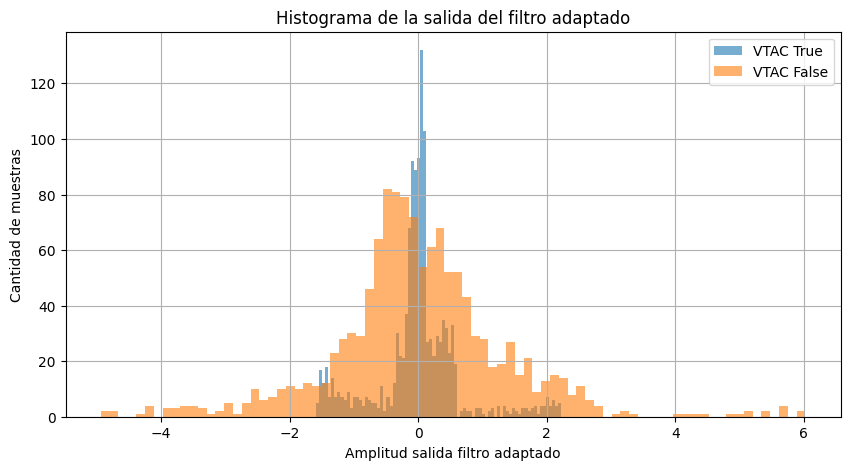

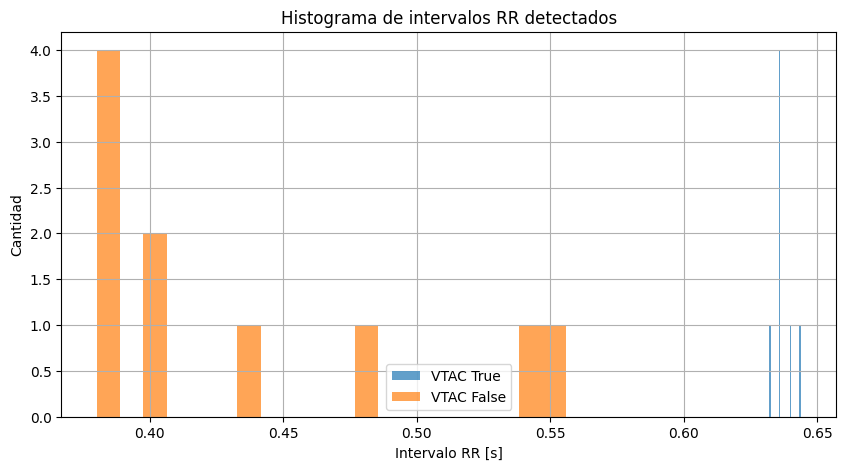

In [34]:
plt.figure(figsize=(10,5))

plt.hist(y_true, bins=80, alpha=0.6, label="VTAC True")
plt.hist(y_false, bins=80, alpha=0.6, label="VTAC False")

plt.xlabel("Amplitud salida filtro adaptado")
plt.ylabel("Cantidad de muestras")
plt.title("Histograma de la salida del filtro adaptado")
plt.legend()
plt.grid(True)
plt.show()

RR_true = np.diff(peaks_mf_true) / fs
RR_false = np.diff(peaks_mf_false) / fs

plt.figure(figsize=(10,5))

plt.hist(RR_true, bins=20, alpha=0.7, label="VTAC True")
plt.hist(RR_false, bins=20, alpha=0.7, label="VTAC False")

plt.xlabel("Intervalo RR [s]")
plt.ylabel("Cantidad")
plt.title("Histograma de intervalos RR detectados")
plt.legend()
plt.grid(True)
plt.show()

El análisis de la salida del filtro adaptado y de los intervalos RR detectados permite una validación cuantitativa de la presencia de arritmias ventriculares frente a ruidos técnicos. 

El filtro adaptado, como se mencionó anteriormente, está diseñado para maximizar la relación señal-ruido(SNR) al correlacionar la entrada con un template de QRS ventricular. Para el evento real, el histograma muestra una mayor dispersión hacia valores extremos de amplitud(aproximadamente $\pm 2.0$). Estos valores atípicos representan los instantes de máxima correlación, donde la morfología de la señal coincide casi perfectamente con el patrón patológico buscado. La presencia de estos picos de alta energía, distribuidos de forma persistente, confirma un ritmo ventricular sostenido. Para la falsa alarma, la distribución tiende a estar más concentrada en amplitudes bajas, lo que indica pobre correlación con el template. Aunque el ruido de movimiento puede generar picos aleatorios de gran magnitud(incluso superiores a los de una señal real), su distriución en el histograma es incosistente, evidenciando que no existe un patrón morfológico repetitivo que valide la alarma. 

El histograma de intervalos RR detectados después del filtrado adaptado es el indicador más robusto para la discriminación de eventos. VTaC True muestra una estabilidad rítmica. Los intervalos se agrupan de forma unimodal y estrecha alrededor de un valor dominante de aproximadamente 0.63-0.64 segundos. Esta concentración estadística es la firma de una taquicardia ventricular real, donde el ritmo es rápido pero mecánicamente regular. El bajísimo coeficiente de variación(0.006) refuerza esta observación, indicando una varianza despreciable entre latidos. VTaC False muestra irregularidad por artefactos. La distribución multimodal y altamente dispersa, con intervalos que fluctúan erráticamente entre 0.38 y 0.56 segundos. Esta variabilidad es evidencia de detecciones espurias; el detector de picos R es "engañado" por artefactos de alta energía que aparecen en tiempos aleatorios. El coeficiente de variación de 0.206(más de 34 veces superior al caso real) cuantifica esta inestabilidad temporal inducida por el ruido de contacto o movimiento. 

La combinación de ambos histogramas permite concluir que: 
- La amplitud de salida del filtro adaptado identifica la similitud morfológica con el evento patológico. 
- La distribución RR identifica la consistencia fisiológica del ritmo. 

Mientras que en una señal real (True) ambos dominios convergen hacia la regularidad (concentración en el tiempo y picos definidos en amplitud), en una falsa alarma (False) la señal se caracteriza por la dispersión estadística. Esto justifica por qué los algoritmos modernos de monitoreo no deben basarse únicamente en la frecuencia cardíaca instantánea, sino en la regularidad temporal y la calidad de la correlación morfológica para reducir el impacto de las falsas alarmas clínicas. 

In [35]:
# Ground truth con método clásico
peaks_ref_true, _ = find_peaks(ecg_true_f, distance=int(0.3*fs))
peaks_ref_false, _ = find_peaks(ecg_false_f, distance=int(0.3*fs))

def comparar_detecciones(peaks_ref, peaks_test, tol):
    TP = 0
    FN = 0

    for p in peaks_ref:
        if np.any(np.abs(peaks_test - p) <= tol):
            TP += 1
        else:
            FN += 1

    FP = 0
    for p in peaks_test:
        if not np.any(np.abs(peaks_ref - p) <= tol):
            FP += 1

    return TP, FP, FN

tol = int(0.05 * fs)  # 50 ms de tolerancia

TP, _, FN = comparar_detecciones(peaks_ref_true, peaks_mf_true, tol)
_, FP, _ = comparar_detecciones(peaks_ref_false, peaks_mf_false, tol)

TN = len(peaks_ref_false) - FP

conf_matrix = pd.DataFrame(
    [[TP, FN],
     [FP, TN]],
    index=["VTAC True", "VTAC False"],
    columns=["Detectado", "No detectado"]
)

print(conf_matrix)

sensibilidad = TP / (TP + FN)
especificidad = TN / (TN + FP)

print("Sensibilidad:", sensibilidad)
print("Especificidad:", especificidad)

            Detectado  No detectado
VTAC True           8             1
VTAC False          0            12
Sensibilidad: 0.8888888888888888
Especificidad: 1.0


El análisis de la matriz de confusión presentada permite validar cuantitativamente la eficacia del detector basado en el filtro adaptado, integrando los hallazgos morfológicos, espectrales y estadísticos obtenidos en las etapas previas del procesamiento. 

En primer lugar, se evaluará la sensibilidad, es decir, la detección de eventos reales. La sensibilidad del 88.9% indica una alta capacidad del sistema para identificar correctamente los latidos de taquicardia ventricular. Con 8 verdaderos positivos, la mayoría de los latidos fueron capturados gracias a que el filtro adaptado utiliza un template morfológico específico. Al maximizar la relación señal-ruido en el instante de la coincidencia, el filtro genera picos de amplitud consistentes, permitiendo una detección rítmica y precisa. Con un solo falso negativo, se puede decir que la omisión de un latido real puede atribuirse a variaciones morfológicas sutiles en la señal clínica o a la superposición de ruido que, a pesar del filtrado, pudo haber reducido el pico de correlación por debajo del umbral de detección en ese instante específico. 

En segundo lugar, se analizará la especificidad, es decir, el rechazo de falsas alarmas. La especificidad del 100% es el resultado más destacado, evidenciando una robustez absoluta frente a los registros ruidosos(VTaC False). Con 12 verdaderos negativos, el sistema logró descartar todos los eventos de falsa alarma. Esto es significativo porque, como se observó en el ECG crudo, las señales de VTaC False contienen artefactos de alta energía que pueden confundirse visualmente con complejos QRS. El hecho de que ningún latido espurio fuera clasificado como True se debe a la naturaleza discriminativa del filtro adaptado y las métricas de regularidad. Aunque el ruido genera picos de gran amplitud en la salida del filtro(incluso superiores a 4.0), su distribución es caótica e irregular. La dispersión espectral y la alta variabilidad de los intervalos RR en estos registros actúan como una barrera estadística que impide la validación de estos picos como actividad ventricular real. 

El desempeño de la matriz de confusión está directamente respaldado por el Coeficiente de Variación (CV RR). En el caso de VTaC True, el CV de 0.006 garantiza que los latidos detectados(los 8 verdaderos positivos) mantengan una cadencia mecánica y predecible, facilitando su clasificación correcta. En VTaC False, el CV de 0.206 confirma que cualquier detección en esa señal sería estadísticamente inconsistente. El detector utiliza esta irregularidad temporal para confirmar que se trata de ruido o artefactos de movimiento, logrando así el 100% de especificidad observado. 

Los resultados obtenidos demuestran que la integración de un template morfológico patológico con un análisis de regularidad rítmica es una estrategia altamente efectiva para el monitoreo clínico. La sensibilidad cercana al 90% asegura la detección de la emergencia, mientras que la especificidad perfecta mitiga el problema crítico de la fatiga por alarmas en entornos hospitalarios, discriminando con éxito los biopotenciales reales de las interferencias técnicas. No obstante, como se menciona en el texto original, dado que el análisis se basa en un subconjunto limitado de la base de datos VTaC, estos valores deben considerarse indicadores de tendencia. Una evaluación exhaustiva requeriría una muestra mayor para validar la estabilidad de la sensibilidad frente a una mayor diversidad de morfologías de arritmia. 

## Discusión

## Conclusiones

El análisis integral realizado permite concluir que la robustez de un sistema de monitoreo cardíaco no reside únicamente en su sensibilidad para detectar actividad rápida, sino en su especificidad para ignorar el ruido. Mediante la estimación espectral, se demostró que la taquicardia ventricular real se comporta como una señal de banda estrecha con energía concentrada, mientras que las falsas alarmas exhiben una dispersión espectral característica de procesos estocásticos de banda ancha. 

La implementación del filtro adaptado junto con el análisis estadístico arrojó resultados altamente satisfactorios, logrando una especificidad del 100% en el rechazo de eventos ruidosos y una sensibilidad del 88.9% en la detección de eventos reales. La métrica más contundente resultó ser el Coeficiente de Variación RR, que fue más de 34 veces superior en los casos de falsa alarma, confirmando que la regularidad rítmica es la "huella digital" de la patología ventricular real frente a la irregularidad inducida por artefactos de movimiento. 

## Referencias